In [1]:
import tensorflow as tf
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt

### Helper Functions

In [2]:
def load_test_data(filename="Chars74K_data.hdf5"):
    with h5py.File("Chars74K_data.hdf5", "r") as f:
        x_test, y_test = f["x_test"][:], f["y_test"][:]
    return x_test, y_test

def compute_gradient(x, label):
    with tf.GradientTape() as tape:
        tape.watch(x)
        prediction = model(x)
        loss = tf.keras.losses.MSE(label, prediction)
    return tape.gradient(loss, x), loss

In [3]:
labels = list(string.ascii_uppercase)

model = tf.keras.models.load_model("Chars74K_model.h5")
x_test, y_test = load_test_data()

x_test = x_test/255
y_test = tf.keras.utils.to_categorical(y_test, len(labels))

### Attack
`new_mi_fgsm()` started off as an implementation of targeted MI-FGSM from [this paper](https://arxiv.org/pdf/1710.06081.pdf). But in the process of trying to get the implementation to work, I found this configuration provided really good results.

In [4]:
def new_mi_fgsm(image, label, decay_factor=1.0, eps=0.1, T=10):
    image = tf.cast(image, tf.float32)
    g = np.full((1, 128, 128, 1), 1e-12, dtype=np.float32)
    adv_x = image # 1, 128, 128, 1
    for t in range(T):
        gradient, loss = compute_gradient(adv_x, label) # Tensors
        loss = loss.numpy()
        L1 = tf.norm(gradient, ord=1).numpy() # Tensor
        
        if L1 == 0: L1 = 1e-12
        
        g = (g * decay_factor) + (loss/L1)
        
        L2 = tf.norm(g, ord=2).numpy()
        if np.isinf(L2): 
            # Dividing by inf gives an error, and x/inf --> 0 so we just set the
            # perturbations to an matrix of zeros
            # It still performed the calculations without this but errors suck
            perturbations = np.full_like(g, 0)
        else: 
            perturbations = (eps * (g/L2))
        adv_x = adv_x - perturbations
    return adv_x.numpy()

### Tests

In [5]:
def attack_successful(img, lbl, epsilon, T):
    # Returns boolean of whether or not attack was successful at fooling model
    truth_lbl = labels[lbl.argmax()]
    adv_example = new_mi_fgsm(img, lbl, eps=epsilon, T=T)
    prediction_lbl = labels[model.predict(adv_example).argmax()]
    if prediction_lbl is not truth_lbl:
        return True, prediction_lbl
    return False, prediction_lbl

In [6]:
def test():
    print("Begining Tests")
    outputs = { letter: set() for letter in labels }
    
    successes = 0
    fails = []
    x_len = len(x_test)
    for idx, img in enumerate(x_test):
        truth_arr = y_test[idx]
        found, prediction = attack_successful(img.reshape((1,128,128,1)), truth_arr, 16, 10)
        if found:
            # Want to check what values adv examples are being mapped to
            outputs[labels[truth_arr.argmax()]].add(prediction)
            successes += 1
        else:
            fails.append(idx)
    print("Number of successes: {}/{}".format(successes, x_len))
    print("Success Rate: ", successes / x_len)
    print("What letters were predicted as: ", outputs)
    print("Failed at indices: ", fails) # Just out of curiosity

Single exmaple of `new_mi_fgsm()` in action

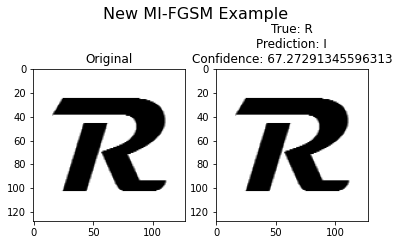

In [7]:
idx = 3405
test_img = x_test[idx].reshape((-1,128,128,1))
y_true = y_test[idx]
true_lbl = labels[y_true.argmax()]

adv_example = new_mi_fgsm(image=test_img, label=y_true, decay_factor=1.0, eps=20, T=25)
adv_pred = model.predict(adv_example)
adv_lbl = labels[adv_pred.argmax()]
confidence = adv_pred.max() * 100

fig = plt.figure()
fig.suptitle("New MI-FGSM Example", fontsize=16)
ax1 = fig.add_subplot(121)
ax1.imshow(test_img.reshape(128,128), cmap="gray")
ax1.title.set_text("Original")

ax2 = fig.add_subplot(122)
ax2.imshow(adv_example.reshape(128,128), cmap="gray")
ax2.title.set_text("True: {}\nPrediction: {}\nConfidence: {}".format(true_lbl, adv_lbl, confidence))

plt.show()

Total Dataset Assessment

In [8]:
# epsilon = 20, T = 25
# These were a bit arbitrarily set but seem to work well
test()

Begining Tests
Number of successes: 4627/5278
Success Rate:  0.876657824933687
